# This is an example of the spam classifier that I used to test which words in the subject lines lead to spam

The goal of an email marketer is to have as many people as possible open and click on the email campaigns that they send.  In order to get a large amount of people to click on the emails, the emails have to land in the inbox.  Therefore, with enough email data, we can use NLP to see what type of language contributes to spam, so that we can decrease our spam rates.

Here we will use a sample dataset to demonstrate how we can achieve our objective.  I used these techniques to optimize my email marketing campaigns but I can not use the same data for this example for privacy reasons, so I will use a made-up dataset.  This dataset resembles what a real world email dataset would look like, containing the sender, subject, and open rate (%).  The open rate is the percentage of people who opened the email.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import nltk
from imblearn.over_sampling import SMOTE

## Basic Data Exploration and Pre-processing

In [3]:
data=pd.read_csv("Sample Email Data - Spam Classifier.csv")
data.head(10)

,Sender,Subject,OpenRate
0,Car Insurance,Compare car insurance quotes online,12.51
1,Prize Promotions,Congratulations!,2.31
2,Car Insurance,You deserve affordable car insurance,8.23
3,Prize Promotions,Please take this survey,12.21
4,Prize Promotions,"Congratulations, here is your free prize!",1.81
5,Survey Partner,How well do you know capital cities?,15.23
6,Mortgage Partner,Cheap rates for refinancing,18.34
7,Prize Promotions,Don’t miss this limited time offer,11.93
8,Prize Promotions,"Congratulations, you have won a free gift card!",3.73
9,Ride Share,"Drive more, pay less",16.77


In [4]:
data.shape

(100, 3)

This dataset has these 10 senders, subject lines and open rates, repeated 10 times for a total of 100 rows.  I created it this way just for demonstration purposes.

With real world email data, there is no clear cut spam/no spam metric.  However, we can tell a campaign spammed when it has an extremely low open rate.  In my experience, most campaigns have about a 7.0-30.0% open rate, depending on a multitude of factors.  Therefore, in practice we use 3.0% as the threshold for spam.  If the open rate is less than 3.0%, we can consider the campaign to have spammed.  Here we will make a column called spam for the emails that spammed.  A value of 1 will signify that the campaign has spammed, whereas a value of 0 will signify that the campaign has not spammed.

In [5]:
data["Spam"]=data["OpenRate"].apply(lambda x: 0 if x>3.0 else 1)

In [6]:
data=data.drop('OpenRate', axis=1)

In [7]:
data.head()

,Sender,Subject,Spam
0,Car Insurance,Compare car insurance quotes online,0
1,Prize Promotions,Congratulations!,1
2,Car Insurance,You deserve affordable car insurance,0
3,Prize Promotions,Please take this survey,0
4,Prize Promotions,"Congratulations, here is your free prize!",1


We can now look at the distribution of spam within our data.

<AxesSubplot:>

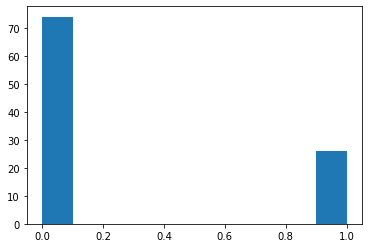

In [8]:
data.Spam.hist(grid=False)

In [9]:
data.Spam.value_counts()

0    74
1    26
Name: Spam, dtype: int64

As we can see, there are about 3 times as many instances of non-spam as there are spam.  It is normal to have a class imbalance with this type of data because if you are appropriately running email marketing campaigns, only a small minority of emails will spam.  However, we will have to deal with this class imbalance to create an accurate model.  We can deal with it in a number of ways, such as under sampling and over sampling, but in my practice I found that the Synthetic Minority Oversampling Technique (SMOTE) works the best, so we will use it here.

In [10]:
sm=SMOTE(sampling_strategy="minority",k_neighbors=2)

## Model Selection and Pre-processing

First we convert our data into input and output data (in this case our input is the subjects lines, and the output is whether or not they spammed).  We will then spilt them into train and test data, using a test size of 20%.

In [11]:
inputs=data['Subject']
spam=data['Spam']

In [12]:
inputs_train, inputs_test, y_train, y_test = train_test_split(inputs, spam, random_state=1, test_size=0.2)

The models we will be testing for this will be Multinomial Naive Bayes, Logistic Regression, Random Forest Classification, Support Vector Classification, and K-Nearest Neighbor Classification.

In [13]:
models=[MultinomialNB(), RandomForestClassifier(), LogisticRegression(), \
        SVC(probability=True),KNeighborsClassifier(n_neighbors=2)]

Prior to testing a model, we have to convert our text data into numerical data.  We can do this by using a vectorizer.  The ones that I tested were the count vectorizer and the TF-IDF vectorizer.  I found that the best preforming vectorizer for me was the TF-IDF vectorizer with English stop words removed, which will be the one we use here.

The text_preprocess() function takes our data inputs and the vectorizer as inputs.  It vecotrizes our data and fixes our class imbalance, and returns our processed X_train, X_test, and y_train variables.

In [14]:
def text_preprocess(vectorizer,inputs_train,inputs_test,y_train, imbalance=True):
    X_train=vectorizer.fit_transform(inputs_train)
    X_test=vectorizer.transform(inputs_test)
    if imbalance==True:
            X_train,y_train=sm.fit_resample(X_train,y_train)
    return X_train,X_test,y_train

In [15]:
vectorizer=TfidfVectorizer(stop_words='english')

Now that our data is processed, we can test our models.  The classifier() function will fit our model onto our data and evaluate its success.  We will mainly be using the F1 score and the AUC score to evaulate our models. 

In [16]:
X_train, X_test, y_train=text_preprocess(vectorizer,inputs_train,inputs_test,y_train,imbalance=True)

In [17]:
def classifier(estimator,X_train,X_test,y_train,y_test):
    model = estimator
    model.fit(X_train, y_train)
    print("train score:", model.score(X_train, y_train))
    print("test score:", model.score(X_test, y_test))
    preds_train=model.predict(X_train)
    preds_test=model.predict(X_test)
    print("train F1 score:", f1_score(y_train, preds_train))
    print("test F1 score:", f1_score(y_test, preds_test))
    prob_train=model.predict_proba(X_train)[:,1]
    prob_test=model.predict_proba(X_test)[:,1]
    print("train AUC:", roc_auc_score(y_train, prob_train))
    print("test AUC:", roc_auc_score(y_test, prob_test))
    print(X_train.shape)
    print(model,"\n")
    return model

In [18]:
for model in models:
    classifier(model, X_train, X_test, y_train, y_test)

train score: 0.9666666666666667
test score: 1.0
train F1 score: 0.967741935483871
test F1 score: 1.0
train AUC: 0.9733333333333334
test AUC: 1.0
(120, 27)
MultinomialNB() 

train score: 0.9666666666666667
test score: 1.0
train F1 score: 0.967741935483871
test F1 score: 1.0
train AUC: 0.9755555555555555
test AUC: 1.0
(120, 27)
RandomForestClassifier() 

train score: 0.9666666666666667
test score: 1.0
train F1 score: 0.967741935483871
test F1 score: 1.0
train AUC: 0.9755555555555555
test AUC: 1.0
(120, 27)
LogisticRegression() 

train score: 0.9666666666666667
test score: 1.0
train F1 score: 0.967741935483871
test F1 score: 1.0
train AUC: 0.9577777777777778
test AUC: 0.9999999999999999
(120, 27)
SVC(probability=True) 

train score: 0.7333333333333333
test score: 0.8
train F1 score: 0.6444444444444445
test F1 score: 0.5
train AUC: 0.9744444444444444
test AUC: 1.0
(120, 27)
KNeighborsClassifier(n_neighbors=2) 



As we can see, all of our models worked well on our fake data.  This is obviously not representative of how these models would perform on real world data, but here I am just demonstrating the code.  In my case, the Random Forest Classifier had the best F1 and AUC scores, and was not overfitting/underfitting (after some hyperparameter tuning).

## Visualization

We can also visualize our data.  In the generate_wordcloud() function, we will be generating a word cloud of the most common words/phrases for each class.  The show_top_words() function will also show the top words in each class, sorted by their count.

In [19]:
def generate_wordcloud(data):
    global all_words
    all_words=''

    for sub in (data):
        sub=sub.lower()
        all_words += sub + ' '

    wordcloud=WordCloud(background_color='white',width=3000, height=1000).generate(all_words)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
    return all_words

In [20]:
def show_top_words(words):
    word_dict={}
    for i in all_words.split():
        if i in list(word_dict.keys()):
            word_dict[i]+=1
        else:
            word_dict[i]=1

    top_words=pd.DataFrame([word_dict]).transpose().reset_index()
    top_words.columns=['Word', 'Count']
    top_10_words=top_words.sort_values(by='Count', ascending=False).head(10)
    return top_10_words

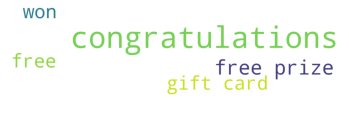

,Word,Count
1,"congratulations,",17
5,free,17
0,congratulations!,9
2,here,9
3,is,9
4,your,9
6,prize!,9
7,you,8
8,have,8
9,won,8


In [21]:
generate_wordcloud(data[data['Spam']==1]['Subject'])
show_top_words(all_words)

As we can see, some of the most common words and phrases that lead to spam based on this dataset are "free", "congratulations", and "free prize" (I specifically made this fake data like this because these words/phrases actually do lead to spam based on my real world analysis/experience).

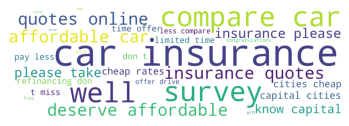

,Word,Count
5,you,22
10,this,20
2,insurance,20
1,car,20
0,compare,10
20,for,10
22,don’t,10
23,miss,10
24,limited,10
26,offer,10


In [22]:
generate_wordcloud(data[data['Spam']==0]['Subject'])
show_top_words(all_words)

These are the common non-spam words/phrases from our data.

## Applying our Model with New Subject Lines

Here we will see how I used our model to predict whether or not my subject lines would spam.  In this case we will be using the Random Forest Classifier as an example model, since it worked the best for me with my real world data.

In [23]:
model=classifier(RandomForestClassifier(), X_train, X_test, y_train, y_test)

train score: 0.9666666666666667
test score: 1.0
train F1 score: 0.967741935483871
test F1 score: 1.0
train AUC: 0.9755555555555555
test AUC: 1.0
(120, 27)
RandomForestClassifier() 



Many email campaigns that we send have multiple possible subject lines.  They range anywhere from about 5-30 subject lines for each campaign.  As a mailer, we can choose to use whichever approved subject line we want.  For demonstration purposes, we will create a set of 10 fake subject lines for an auto insurance promotion.  We will then run our model on these subject lines to see if they are likely to spam.

In [24]:
new_subjects={"Subject":["Need better auto insurance?","Congratulations!", "You have been selected", "Enjoy a free quote", \
                "You have won a free auto prize!", "Affordable car insurance", "Want to save on auto insurance?", \
               "Cheap insurance rates, just for you", "Here is your free quote", "Congratulations on your free quote!"]}

In [25]:
new_subjects=pd.DataFrame(new_subjects)
new_subjects

,Subject
0,Need better auto insurance?
1,Congratulations!
2,You have been selected
3,Enjoy a free quote
4,You have won a free auto prize!
5,Affordable car insurance
6,Want to save on auto insurance?
7,"Cheap insurance rates, just for you"
8,Here is your free quote
9,Congratulations on your free quote!


In [26]:
new_vect=vectorizer.transform(new_subjects.Subject)

In [27]:
class_preds=model.predict(new_vect)
class_preds=pd.DataFrame(class_preds)

In [28]:
preds_proba=model.predict_proba(new_vect)[:,1]
preds_proba=pd.DataFrame(preds_proba)

In [29]:
final_df=new_subjects.merge(class_preds, left_index=True, right_index=True)

In [30]:
final_df=final_df.merge(preds_proba, left_index=True, right_index=True)

In [31]:
final_df.columns=['Subject', 'Class Prediction', 'Spam Probability']

In [32]:
final_df

,Subject,Class Prediction,Spam Probability
0,Need better auto insurance?,0,0.085092
1,Congratulations!,1,0.936583
2,You have been selected,0,0.092092
3,Enjoy a free quote,0,0.372479
4,You have won a free auto prize!,1,0.638811
5,Affordable car insurance,0,0.027537
6,Want to save on auto insurance?,0,0.085092
7,"Cheap insurance rates, just for you",0,0.038222
8,Here is your free quote,0,0.372479
9,Congratulations on your free quote!,1,0.940841


As you can see here, the "Congratulations!", "You have won a free auto prize!", and "Congratulations on your free quote!" subject lines from our new campaign are likely to spam, so I would not include these subject lines in my email campaigns.  Additionally, I would run subject lines that have both a 0 class prediction and a low spam probability.  For example, "Cheap insurance rates, just for you" (0.038 probability of spam) is better than "Enjoy a free quote" (0.372 probability of spam).